 <h1><big><center>GAN-based Photo Realistic Single Image Super Resolution</center></big></h1>
 <h3><big><center><a href="https://github.com/souhaiel1"> Souhaiel Ben Salem</a></center></big></h3>
 <h3><center>souhaiel.ben_salem@ens-paris-saclay.fr</center></h3>

Super resolution is a fundamental problem in computer vision, which aims at generating high-resolution images from low-resolution inputs. In recent years, deep learning approaches have shown promising results in addressing this challenge. In this project, we present a comprehensive review of deep learning-based super resolution methods, with a particular focus on GAN-based architectures such as [SRGAN](https://arxiv.org/abs/1609.04802)  and [ESRGAN](https://arxiv.org/abs/1809.00219) . We discuss the key components of state-of-the-art super resolution networks, including feature extraction, feature fusion, and reconstruction. We also takcle the DIV2K dataset using these approaches while exploring the different training strategies and loss functions that have been proposed to enhance the performance of super resolution models. Furthermore, we provide an overview of benchmark datasets and evaluation metrics for our super resolution models. 

# SRGAN with a different (potentially improved perceptual loss) 

The primary objective is to train a generative function $G$ that can accurately estimate the corresponding high-resolution (HR) counterpart for any given low-resolution (LR) input image. \\
The authors use generative function $G$, which is a feed-forward convolutional neural network, specifically, a deep $ResNet$ (SRReset) parametrized by $\theta_G$. Where, $\theta_G = \{W_{1:L}; b_{1:L}\}$ are the weights and biases of an L-layer deep network. We optimize a super-resolution specific perceptual loss function $l_{SR}$ to obtain $\theta_G$. The generator function is trained on a set of training images ${I_{HR_n}, I_{LR_n}}$, where $n = 1, ..., N$ (N = 800 for DIV2K).\\
We aim to minimize the following objective function:
\begin{equation}
    \hat{\theta_G} = \arg \min_{\theta_G} \frac{1}{N}\sum_{n=1}^{N} l^{SR}(G_{\theta_G}(I^{LR}_n), I^{HR}_n)
\end{equation}

\noindent We introduce a discriminator network $D_{\theta_D}$, which is optimized in an alternating manner with $G_{\theta_G}$ to solve the adversarial min-max problem. This problem aims to find the optimal values of $\theta_G$ and $\theta_D$ that can generate super-resolved images that are indistinguishable from the high-resolution images in the training set. The objective function for this problem is defined as follows:
\begin{align*}
\min_{\theta_G}\max_{\theta_D} E_{I^{HR} \sim p_{train}(I^{HR})} [\log D_{\theta_D}(I^{HR})] + \\
                    E_{I^{LR} \sim p_{G}(I^{LR})} [\log (1 - D_{\theta_D}(G_{\theta_G}(I^{LR})))] \ \ \ \ \ \  \  (2)
\end{align*}

\noindent The main idea of using such a formulation is to train a generative model $G$ to produce super-resolved images that can fool a differentiable discriminator $D$, which is trained to distinguish between real images and super-resolved images. By adopting this approach, the generator network can learn to generate solutions that are photo realistic and difficult for the discriminator network to classify, leading to perceptually superior results that lie in the manifold of natural images. This is in contrast to traditional super-resolution methods that minimize pixel-wise error measurements such as the $MSE$, which often results in overly smooth and unrealistic super-resolved images.\\
The architecture of the SRGAN model consists of a  deep generator network $G$, which is composed of $16$ residual blocks with identical layout. Each residual block has two convolutional layers with $3x3$ kernels and $64$ feature maps, followed by $batch-normalization$ layers and $ParametricReLU$ as the activation function. The resolution of the input image is increased with two trained sub-pixel convolution layers ($PixelShuffle$ layers). We train the discriminator network to tell real $HR$ images from generated $SR$ samples. The discriminator network consist of eight convolutional layers with an increasing number of $3x3$ filters , increasing by a factor of 2 from 64 to 512 kernels, as in the $VGG$ network and strided convolutions are used to reduce the image resolution each time the number of features is doubled. The resulting 512 feature maps are followed by two dense layers and a final $sigmoid$ activation function to enforce a probability for sample classification. We use a $LeakyReLU$  ($\alpha$ = 0.2) is used while avoiding max-pooling throughout the network. \\
The architecture of the model is summarized in the followig figure.

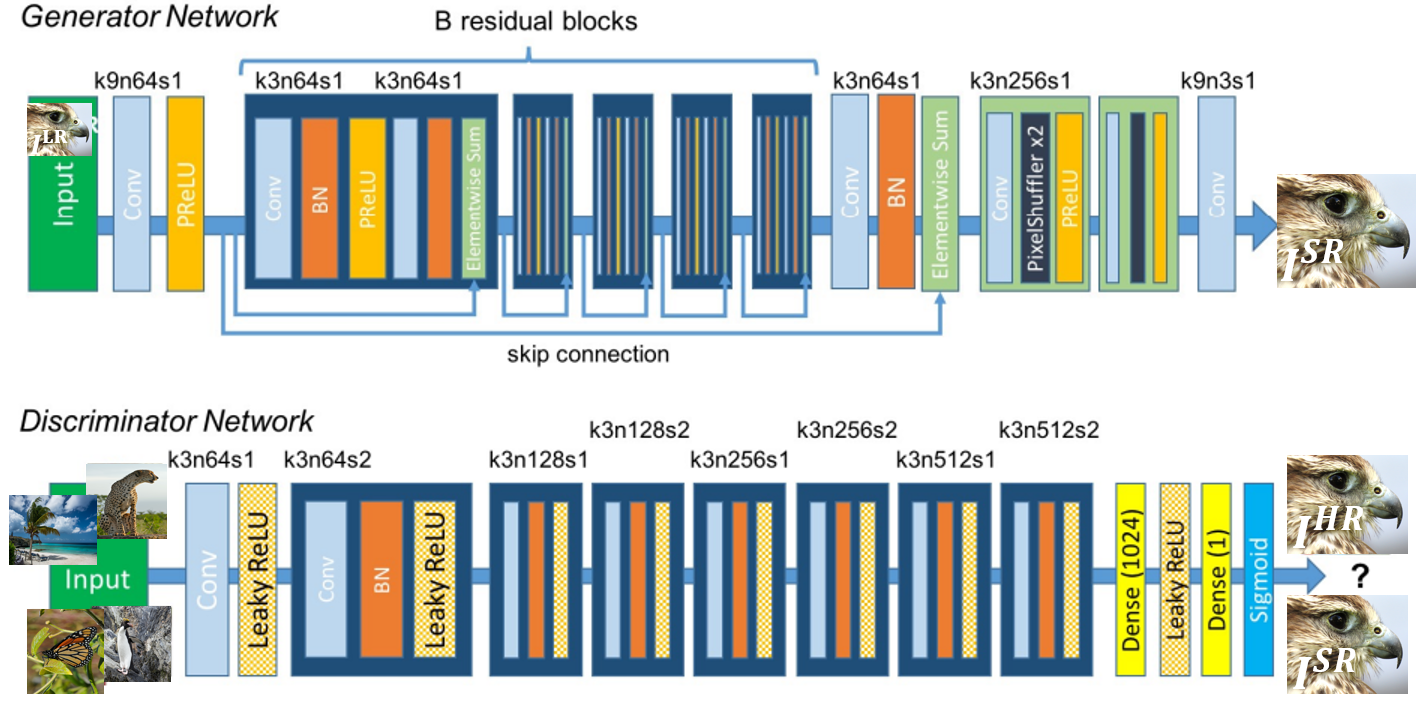

#### Imports and prerequisites 

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-n_ylt5lt
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-n_ylt5lt
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125709 sha256=e3f216225dbf281d2a1655b1b6b33e19dce16e281e1e2257793631871a0c5492
  Stored in directory: /tmp/pip-ephem-wheel-cache-jpakz6kc/wheels/6d/72/93/d30af2a1f90e7c7e811e8fa43aa723971c91af45052ffa1b5a
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
import torch 
from torch import nn 
from torchvision.models import vgg19
from torch.utils.data import Dataset
import glob
import os
from PIL import Image
from torchvision.transforms import ToTensor
import numpy as np
from torch.utils.data.dataset import Dataset
import torchvision.transforms as T
import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchsummary import summary
import os
import sys
from pathlib import Path 

## Building Blocks

In [ ]:
class ConvBlock(nn.Module): 
  def __init__(self,in_channels,out_channels,discriminator = False,ACTIVATION = True, BATCH_NORM=True, **kwargs): 
    super().__init__()
    self.ACTIVATION=ACTIVATION
    self.cnn = nn.Conv2d(in_channels,out_channels,**kwargs, bias = not BATCH_NORM ) # biases are only used when we don't use batch normalization
    self.batch_normalization = nn.BatchNorm2d (out_channels) if BATCH_NORM else nn.Identity()
    self.activation = (nn.LeakyReLU(negative_slope=0.2) 
                      if discriminator 
                      else nn.PReLU() 
                      )
    
  def forward (self,input):
    input = self.cnn(input)
    if self.ACTIVATION: 
      input = self.batch_normalization(input)
      output = self.activation(input)
    else: 
      output = self.batch_normalization(input)
    return output


In [ ]:
class UpBlock (nn.Module): 
  def __init__(self,input_size,factor): 
    super().__init__()
    self.convlayer=nn.Conv2d(input_size, input_size*factor**2 ,3,1,1)
    self.pix_shuffle = nn.PixelShuffle(factor)
    self.activation= nn.PReLU(input_size)
  def forward(self,input):
    input = self.convlayer(input)
    input = self.pix_shuffle(input) # outputs an imae of size factor*H , factor*W
    output = self.activation(input)
    return output


In [ ]:
# we need B Residual Blocks
class ResBlock(nn.Module):
  def __init__(self,input_size): 
    super().__init__()
    self.block1 = ConvBlock(input_size,input_size, kernel_size=3, stride=1, padding=1)
    self.block2 = ConvBlock(input_size,input_size, kernel_size=3, stride=1, padding=1, ACTIVATION=False)
  def forward(self,input):
    output = self.block1(input)
    output = self.block2(output)
    return output + input # skip connections

Now we will the Generator and Discrimintor as described in the previous figure above. 

## Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self,in_channels=3, num_channels=64,B=16): 
    super().__init__()
    self.conv1 = ConvBlock(in_channels,num_channels, kernel_size=9,stride=1,padding=4,BATCH_NORM=False)
    self.resblocks = nn.Sequential(*[ResBlock(num_channels) for i in range(B)]) # B*residual blocks
    self.conv2 = ConvBlock(num_channels,num_channels,kernel_size=3, stride =1, padding=1,ACTIVATION=False)
    self.upsample1= UpBlock(num_channels,2)
    self.upsample2= UpBlock(num_channels,2)
    self.conv3 = nn.Conv2d(num_channels,in_channels,kernel_size=9,stride=1,padding=4)
  def forward(self,input):
    output1 = self.conv1(input)
    input = self.resblocks(output1)
    input = self.conv2(input) + output1 # skip connection
    input = self.upsample1(input)
    input = self.upsample2(input)
    input = self.conv3(input)
    output = torch.tanh(input) # we add tanh because in the paper it is mentioned that they normalize the output to be in [-1,1]
    return output

## Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,in_channels=3,out_channels=64):
    super().__init__()
    self.entry_block=ConvBlock(in_channels,out_channels,kernel_size=3,stride=1,padding=1,BATCH_NORM=False)
    self.conv_blocks=nn.Sequential(
        ConvBlock(in_channels=64,out_channels=64,kernel_size=3,stride=2,padding=1),
        ConvBlock(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
        ConvBlock(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1),
        ConvBlock(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
        ConvBlock(in_channels=256,out_channels=256,kernel_size=3,stride=2,padding=1),
        ConvBlock(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),
        ConvBlock(in_channels=512,out_channels=512,kernel_size=3,stride=2,padding=1)
    )
    
    self.out_block = nn.Sequential(
        nn.AdaptiveAvgPool2d(1), 
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)
         
    )

  def forward(self,input): 
    batch_size = input.size(0)
    input = self.entry_block(input)
    input = self.conv_blocks(input)
    output = self.out_block(input)
    #output = output.view(batch_size)
    output = output.flatten(start_dim=1)
    return torch.sigmoid(output)


In [ ]:
# Test generator and discriminator 
gen = Generator()
disc = Discriminator()
low_res = 24
x = torch.randn((5, 3, low_res, low_res))
gen_out = gen(x)
disc_out = disc(gen_out)

print(gen_out.shape)
print(disc_out.shape)


torch.Size([5, 3, 96, 96])
torch.Size([5, 1])


## Perceptual Loss 

The main contribution introduced by authors of the SRGAN paper is the use of the GAN architecture and the introduction of a novel perceptual loss function that consists of an adversarial loss and a content loss based on VGG's feature maps. This loss function is proved to be much better than MSE at capturing perceptually relevant differences. $$l^{SR}= \underbrace{6.10^{-3}l_{VGG/5,4}^{SR}}_{content \ loss} + \underbrace{10^{-3} l_{Gen}^{SR}}_{adversarial \ loss}$$ 
Where The generative loss $l_{SR}^{Gen}$ is defined based on the probabilities of the discriminator $D_{\theta_D}(G_{\theta_G}(I_{LR}))$ over all training samples as:

$$l^{SR}_{Gen} = -\sum_{n=1}^N \log D_{\theta_D}(G_{\theta_G}(I^{LR}))$$

Our approach consisted of implementing the SRGAN architecture proposed by the authors while making changes on the perceptual loss function and the training process. \\

**Modified perceptual loss function for SRGAN:**

\noindent  through intuition and experimentation, we introduce the following perceptual loss function: 
$$l^{SR}_{modified}= \underbrace{l_{MSE}^{SR}}_{pixel 
\ loss}+ \underbrace{6.10^{-3}l_{VGG/5,4}^{SR}}_{content \ loss} + \underbrace{10^{-3} l_{Gen}^{SR}}_{adversarial \ loss} + \underbrace{2.10^{-8}l_{TV}^{SR}}_{total \ variation} $$ \\

In [ ]:
# total variation loss (regularization technique to help reduce noise and artifacts)
class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

In [ ]:
# our proposed perceptual loss  : Adversarial Loss, VGG Loss, and TV Loss.
class PerceptualLoss(nn.Module):
  def __init__(self,vgg_loss_w,adversarial_loss_w):
      super(PerceptualLoss, self).__init__()
      vgg = vgg19(pretrained=True)
      loss_network = nn.Sequential(*list(vgg.features)[:36]).eval()
      for param in loss_network.parameters():
          param.requires_grad = False
      self.loss_network = loss_network
      self.mse_loss = nn.MSELoss()
      self.vgg_loss_w = vgg_loss_w
      self.adversarial_loss_w = adversarial_loss_w
      self.tv_loss = TVLoss()

  def forward(self, out_labels, out_images, target_images):
      # Adversarial Loss
      adversarial_loss = torch.mean(1 - out_labels)
      adversarial_loss = self.adversarial_loss_w* adversarial_loss
      # VGG Loss
      perceptual_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
      perceptual_loss = self.vgg_loss_w* perceptual_loss
      # Image Loss
      standard_mse_loss = self.mse_loss(out_images, target_images)
      # TV Loss
      tv_loss = self.tv_loss(out_images)
      tv_loss = 2e-8 * tv_loss
      return standard_mse_loss, adversarial_loss, perceptual_loss, tv_loss

## DIV2K Dataset

In [ ]:
class DIV2K(Dataset):
	def __init__(self, data_dir, transform=ToTensor()):
		# Get all paths of images inside `data_dir` into a list
		pattern = os.path.join(data_dir, "**/*.png")
		self.file_paths = sorted(glob.glob(pattern, recursive=True))
		self.transform = transform

	def __len__(self):
		return len(self.file_paths)

	def __getitem__(self, index):
		file_name = self.file_paths[index].split('/')[-1]
		img = Image.open(self.file_paths[index])
		img = self.transform(img)
		return img, file_name

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {str(device).upper()}")

device: CUDA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_HR = "/content/drive/MyDrive/DIV2K_train_HR"
TRAIN_LR = "/content/drive/MyDrive/DIV2K_train_LR_bicubic/X4"
VAL_HR = "/content/drive/MyDrive/DIV2K_valid_HR"
VAL_LR = "/content/drive/MyDrive/DIV2K_valid_LR_bicubic/X4"

In [ ]:
LR_CROPPED_SIZE = 24
UPSCALE = 4
HR_CROPPED_SIZE = UPSCALE * LR_CROPPED_SIZE
BATCH_SIZE = 16
EPOCHS = 50
LR = 0.0001
BETAS = (0.5, 0.9)
PATH_G = Path("/content/drive/MyDrive/SR_models/Gen/G.pt")
PATH_D = Path("/content/drive/MyDrive/SR_models/Disc/D.pt")
adversarial_loss_coef = 0.001
vgg_loss_coef = 0.006

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# Custom class to use if Albumentations is used instead of torchvision.transforms
import cv2
import numpy as np
class ImageDataset(Dataset):
	def __init__(self, data_dir, transform=None):
		# Get all paths of images inside `data_dir` into a list
		pattern = os.path.join(data_dir, "**/*.png")
		self.file_paths = sorted(glob.glob(pattern, recursive=True))
		self.transform = transform

	def __len__(self):
		return len(self.file_paths)

	def __getitem__(self, index):
		file_name = self.file_paths[index].split('/')[-1]
		img = np.array(Image.open(self.file_paths[index]))
		img = self.transform(image=img)["image"]
		return img, file_name

In [ ]:
# Transformations using Albumentations
transform_hr = A.Compose([
	A.CenterCrop(HR_CROPPED_SIZE,HR_CROPPED_SIZE),
	A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
  A.HorizontalFlip(p=0.5),
  A.RandomRotate90(p=0.5),
	ToTensorV2()
])

transform_lr = A.Compose([
	A.CenterCrop(LR_CROPPED_SIZE,LR_CROPPED_SIZE),
	A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
  A.HorizontalFlip(p=0.5),
  A.RandomRotate90(p=0.5),
  ToTensorV2(),
])

In [ ]:
# Transformation used in the paper
transform_hr = T.Compose([
	T.CenterCrop(HR_CROPPED_SIZE),
	T.ToTensor()
])
transform_lr = T.Compose([
	T.CenterCrop(LR_CROPPED_SIZE),
	T.ToTensor()
])

In [ ]:
def load_training_data():
	data_train_hr = DIV2K(data_dir=os.path.join(TRAIN_HR), transform=transform_hr)
	data_train_lr = DIV2K(data_dir=os.path.join(TRAIN_LR), transform=transform_lr)
	return data_train_hr, data_train_lr

def save_checkpoints(G, D, optimizer_G, optimizer_D, epoch):
	checkpoint_G = {
		'model': G,
		'state_dict': G.state_dict(),
		'optimizer': optimizer_G.state_dict(),
		'epoch': epoch
	}
	checkpoint_D = {
		'model': D,
		'state_dict': D.state_dict(),
		'optimizer': optimizer_D.state_dict(),
	}
	torch.save(checkpoint_G, PATH_G)
	torch.save(checkpoint_D, PATH_D)

def load_checkpoints(G, D, optimizerG, optimizerD):
	print("Loading checkpoints ...")
	checkpoint_G = torch.load(PATH_G)
	checkpoint_D = torch.load(PATH_D)
	G.load_state_dict(checkpoint_G['state_dict'])
	optimizerG.load_state_dict(checkpoint_G['optimizer'])
	D.load_state_dict(checkpoint_D['state_dict'])
	optimizerD.load_state_dict(checkpoint_D['optimizer'])
	prev_epochs = checkpoint_G['epoch']

	print("Loaded checkpoints successfully!")
	return G, D, optimizerG, optimizerD, prev_epochs

# initialize weights and make sure the variance of the activations are the same across every layer
def init_weights(model):
	if isinstance(model, torch.nn.Linear) or isinstance(model, torch.nn.Conv2d):
		torch.nn.init.xavier_uniform_(model.weight)

In [ ]:
# Custom pixel Loss (weighted mean loss)
class PixLoss(nn.Module):
    '''Pixel-wise MSE loss for images''' 
    def __init__(self, alpha=10):
        super().__init__()
        self.alpha=alpha

    def forward(self, fake, real):
        return self.alpha* torch.mean((fake - real)**2)

In [ ]:
def train(resume_training=True):
	### Load data
	data_train_hr, data_train_lr = load_training_data()
	hr_train_loader = DataLoader(dataset=data_train_hr, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)
	lr_train_loader = DataLoader(dataset=data_train_lr, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)
	assert len(hr_train_loader) == len(lr_train_loader)

	### Load models
	G =Generator(in_channels=3).to(device)
	D = Discriminator().to(device)
 
 
	optimizer_G = optim.Adam(G.parameters(), lr=LR, betas=BETAS)
	optimizer_D = optim.Adam(D.parameters(), lr=LR, betas=BETAS)

	if resume_training and PATH_G.exists() and PATH_D.exists():
		G, D, optimizer_G, optimizer_D, prev_epochs = load_checkpoints(G, D, optimizer_G, optimizer_D)
		print("Continue training from previous checkpoints ...")
		warmup = False
	else:
		G.apply(init_weights)
		D.apply(init_weights)
		prev_epochs = 0
		summary(G, input_size=(3, LR_CROPPED_SIZE, LR_CROPPED_SIZE), batch_size=BATCH_SIZE, device=str(device))
		summary(D, input_size=(3, HR_CROPPED_SIZE, HR_CROPPED_SIZE), batch_size=BATCH_SIZE, device=str(device))
		print("Training from start ...")
		warmup = True

	### Train
	G.train()
	D.train()

	criterion_G = PerceptualLoss(vgg_loss_w=vgg_loss_coef, adversarial_loss_w=adversarial_loss_coef).to(device)
	warmup_loss =  torch.nn.L1Loss()
	criterion_D = torch.nn.BCELoss()

	## Warm up G
	if warmup:
		for w in range(100):
			print(f"\nWarmup: {w+1}")
			for (batch, hr_batch), lr_batch in zip(enumerate(hr_train_loader), lr_train_loader):
				hr_img, lr_img = hr_batch[0].to(device), lr_batch[0].to(device)
				optimizer_G.zero_grad()

				sr_img = G(lr_img)
				err_G = warmup_loss(sr_img, hr_img)
				err_G.backward()

				optimizer_G.step()
				if batch % 5 == 0:
					print(f"\tBatch: {batch + 1}/{len(data_train_hr) // BATCH_SIZE}")
					print(f"\tMAE G: {err_G.item():.4f}")

	for e in range(EPOCHS):
		print(f"\nEpoch: {e+prev_epochs+1}")

		for (batch, hr_batch), lr_batch in zip(enumerate(hr_train_loader), lr_train_loader):
			# Transfer data to GPU if available
			hr_img, lr_img = hr_batch[0].to(device), lr_batch[0].to(device)

			#### TRAIN D: maximize `log(D(x)) + log(1-D(G(z)))`
			optimizer_D.zero_grad()

			# Classify all-real HR images
			real_labels = torch.full(size=(len(hr_img),), fill_value=0.99, dtype=torch.float, device=device)
			output_real = D(hr_img).view(-1)
			err_D_real = criterion_D(output_real, real_labels)
			err_D_real.backward()

			# Classify all-fake HR images (or SR images)
			fake_labels = torch.full(size=(len(hr_img),), fill_value=0.0, dtype=torch.float, device=device)
			sr_img = G(lr_img)
			output_fake = D(sr_img.detach()).view(-1)
			err_D_fake = criterion_D(output_fake, fake_labels)
			err_D_fake.backward()

			optimizer_D.step()
			D_Gz1 = output_fake.mean().item()

			#### TRAIN G: minimize `log(D(G(z))`
			optimizer_G.zero_grad()

			output_fake = D(sr_img).view(-1)
			pixel_loss, adversarial_loss, vgg_loss,tv_loss = criterion_G(output_fake,sr_img, hr_img)
			err_G = pixel_loss + adversarial_loss + vgg_loss + tv_loss
			err_G.backward()
			optimizer_G.step()

			# Print stats
			if batch%10==0:
				print(f"\tBatch: {batch + 1}/{len(data_train_hr) // BATCH_SIZE}")
				D_x = output_real.mean().item()
				D_Gz2 = output_fake.mean().item()
				print(f"\terr_D_real: {err_D_real.item():.4f}; err_D_fake: {err_D_fake.item():.4f}; "
					  f" err_G: {err_G.item():.4f}; D_x: {D_x:.4f}; D_Gz1: {D_Gz1:.4f}; D_Gz2: {D_Gz2:.4f}")
				print(f"\t adversarial_loss: {adversarial_loss:.4f}, vgg_loss: {vgg_loss:.4f}, "
					  f"pixel_loss: {pixel_loss:.4f}")
			## Free up GPU memory
			del hr_img, lr_img, err_D_fake, err_D_real, err_G, real_labels, fake_labels, \
				output_real, output_fake, sr_img, pixel_loss, adversarial_loss, vgg_loss
			torch.cuda.empty_cache()

		### Save checkpoints
		save_checkpoints(G, D, optimizer_G, optimizer_D, epoch=prev_epochs+e+1)



In [ ]:
train(resume_training=True)

Loading checkpoints ...
Loaded checkpoints successfully!
Continue training from previous checkpoints ...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 801
	Batch: 1/50
	err_D_real: 0.0560; err_D_fake: 0.0000;  err_G: 0.0028; D_x: 0.9900; D_Gz1: 0.0000; D_Gz2: 0.0000
	 adversarial_loss: 0.0010, vgg_loss: 0.0001, pixel_loss: 0.0017
	Batch: 11/50
	err_D_real: 0.0560; err_D_fake: 0.0000;  err_G: 0.0026; D_x: 0.9898; D_Gz1: 0.0000; D_Gz2: 0.0000
	 adversarial_loss: 0.0010, vgg_loss: 0.0001, pixel_loss: 0.0015
	Batch: 21/50
	err_D_real: 0.0560; err_D_fake: 0.0000;  err_G: 0.0031; D_x: 0.9901; D_Gz1: 0.0000; D_Gz2: 0.0000
	 adversarial_loss: 0.0010, vgg_loss: 0.0001, pixel_loss: 0.0019
	Batch: 31/50
	err_D_real: 0.0560; err_D_fake: 0.0000;  err_G: 0.0027; D_x: 0.9901; D_Gz1: 0.0000; D_Gz2: 0.0000
	 adversarial_loss: 0.0010, vgg_loss: 0.0001, pixel_loss: 0.0016
	Batch: 41/50
	err_D_real: 0.0560; err_D_fake: 0.0000;  err_G: 0.0031; D_x: 0.9901; D_Gz1: 0.0000; D_Gz2: 0.0000
	 adversarial_loss: 0.0010, vgg_loss: 0.0001, pixel_loss: 0.0020

Epoch: 802
	Batch: 1/50
	err_D_real: 0.0560; err_D_fake: 0.0000;  err_G: 0.0028; D_x: 0.9901; D_Gz

In [ ]:
def load_test_data():
	data_test_hr = DIV2K(data_dir=os.path.join(VAL_HR), transform=transform_hr)
	data_test_lr = DIV2K(data_dir=os.path.join(VAL_LR), transform=transform_lr)
	hr_test_loader = DataLoader(dataset=data_test_hr, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)
	lr_test_loader = DataLoader(dataset=data_test_lr, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

	assert len(hr_test_loader) == len(lr_test_loader)
	return hr_test_loader, lr_test_loader

def load_checkpoints(G, D):
	checkpoint_G = torch.load(PATH_G)
	checkpoint_D = torch.load(PATH_D)
	G.load_state_dict(checkpoint_G['state_dict'])
	D.load_state_dict(checkpoint_D['state_dict'])

	print("Loaded checkpoints successfully!")
	return G, D

In [ ]:
def tensor_to_img(tensor):
  tensor = tensor.cpu()
  pil = T.ToPILImage()(tensor.squeeze_(0))
  return pil
 

In [ ]:
# model stopped at 605 epochs
Path_G605= Path("/content/drive/MyDrive/SR_models/gen605/G.pt")

In [ ]:
# different benchmark sets
SR_DIR ="/content/drive/MyDrive/SR_models"
set5_lr = "/content/drive/MyDrive/set5_LR"
set5_hr = "/content/drive/MyDrive/set5_HR"
set14_lr = "/content/drive/MyDrive/set14_LR"
set14_hr = "/content/drive/MyDrive/set14_HR"
set5_supres = "/content/drive/MyDrive/set5_superres"
set14_supres = "/content/drive/MyDrive/set14_superres"

In [ ]:
SR_DIR=set14_supres
def generate_sr(lr_img_path):
	with torch.no_grad():
		pil_img = Image.open(lr_img_path)
		img_tensor = T.ToTensor()(pil_img)
		img_tensor = torch.unsqueeze(img_tensor, 0) # add batch dimension
		img_tensor = img_tensor.to(device)
		sr_img = G(img_tensor)
		sr_img = torch.abs(sr_img)
		print(f"Upscaled from size [{img_tensor.shape[2]}, {img_tensor.shape[3]}] to [{sr_img.shape[2]}, {sr_img.shape[3]}]")

	file_name = lr_img_path.split('/')[-1]
	sr_img_path = os.path.join(SR_DIR, f"sr_{file_name}")
	tensor_to_img(sr_img, sr_img_path)

def tensor_to_img(tensor, filepath):
	tensor = tensor.cpu()
	pil = T.ToPILImage()(tensor.squeeze_(0))
	pil.save(filepath)
	print(f"Saved to {filepath}")

In [ ]:
# test cell to super resolve 1 image
lr_test_dir =VAL_LR 
G = Generator(in_channels=3)
if PATH_G.exists():
		checkpoint_G = torch.load(PATH_G)
		G.load_state_dict(checkpoint_G['state_dict'])
		G.to(device)
else:
		print("Checkpoints not found, using Xavier initialization.")
		G.apply(init_weights).to(device)
G.eval()
	
generate_sr("/content/drive/MyDrive/DIV2K_valid_LR_bicubic/X4/0801x4.png")

Upscaled from size [339, 510] to [1356, 2040]
Saved to /content/drive/MyDrive/SR_models/sr_0801x4.png


In [ ]:
# super resolve set14
lr_test_dir =set14_lr 
G = Generator(in_channels=3)
if PATH_G.exists():
		checkpoint_G = torch.load(PATH_G)
		G.load_state_dict(checkpoint_G['state_dict'])
		G.to(device)
else:
		print("Checkpoints not found, using Xavier initialization.")
		G.apply(init_weights).to(device)
G.eval()

for filename in os.listdir(lr_test_dir):
	
	generate_sr(set14_lr + '/' + filename)

Upscaled from size [120, 125] to [480, 500]
Saved to /content/drive/MyDrive/set14_superres/sr_img_001_SRF_4_LR.png
Upscaled from size [97, 146] to [388, 584]
Saved to /content/drive/MyDrive/set14_superres/sr_img_014_SRF_4_LR.png
Upscaled from size [164, 132] to [656, 528]
Saved to /content/drive/MyDrive/set14_superres/sr_img_013_SRF_4_LR.png
Upscaled from size [128, 128] to [512, 512]
Saved to /content/drive/MyDrive/set14_superres/sr_img_012_SRF_4_LR.png
Upscaled from size [69, 69] to [276, 276]
Saved to /content/drive/MyDrive/set14_superres/sr_img_006_SRF_4_LR.png
Upscaled from size [72, 88] to [288, 352]
Saved to /content/drive/MyDrive/set14_superres/sr_img_004_SRF_4_LR.png
Upscaled from size [72, 88] to [288, 352]
Saved to /content/drive/MyDrive/set14_superres/sr_img_008_SRF_4_LR.png
Upscaled from size [90, 125] to [360, 500]
Saved to /content/drive/MyDrive/set14_superres/sr_img_007_SRF_4_LR.png
Upscaled from size [128, 128] to [512, 512]
Saved to /content/drive/MyDrive/set14_superr

#### Quality measures (PSNR and SSIM)

In [ ]:
import  skimage.metrics as metrics
from skimage.color import rgb2ycbcr,rgb2yuv


def PSNR(gt, pred):
      #gt = gt.astype(np.float64)
      #pred = pred.astype(np.float64)
      #mse = np.mean((pred - gt)**2)
      #psnr = 10*np.log10(255*255/mse)
      #return psnr
      return metrics.peak_signal_noise_ratio(gt, pred, data_range=255)
    
def SSIM(gt, pred):
      ssim = metrics.structural_similarity(gt, pred, data_range=255, gaussian_weights=True)
      return ssim

def test_images( gt, pred):

    avg_psnr = 0
    avg_ssim = 0
    individual_psnr = []
    individual_ssim = []

    for i in range(len(pred)):
      # compare to gt
      psnr = PSNR(luminance(gt[i]), luminance(pred[i]))
      ssim = SSIM(luminance(gt[i]), luminance(pred[i]))
      # save results to log_path ex: 'results/experiment1/Set5/baby/1000.png'
      #if save_images:
      #  path = os.path.join(log_path, self.name, self.names[i])
      # gather results
      individual_psnr.append(psnr)
      individual_ssim.append(ssim)
      avg_psnr += psnr
      avg_ssim += ssim
    
    avg_psnr /= len(pred)
    avg_ssim /= len(pred)
    print("avg_psnr:",avg_psnr)
    print("avg_ssim:",avg_ssim)


In [ ]:
!pip install -U scikit-image

In [ ]:
def luminance( image):
    # Get luminance
    lum = rgb2ycbcr(image)[:,:,0]
    # Crop off 4 border pixels
    lum = lum[4:lum.shape[0]-4, 4:lum.shape[1]-4]
    #lum = lum.astype(np.float64)
    return lum

In [ ]:
# ignore this cell
# test cell
im1 =np.array(Image.open("/content/drive/MyDrive/DIV2K_valid_HR/0870.png"))
im2 = np.array(Image.open("/content/drive/MyDrive/superres_imgs/sr_0870x4.png"))
print(metrics.mean_squared_error(luminance(im1),luminance(im2)))

268.0720757377332


In [ ]:
# ignore this cell
# test cells 
im1 =np.array(Image.open("/content/drive/MyDrive/DIV2K_valid_HR/0870.png"))
im2 = np.array(Image.open("/content/drive/MyDrive/superres_imgs/sr_0870x4.png"))
print(metrics.mean_squared_error(im1,im2))

368.5115143067405


#### Evaluate on DIV2K  


In [ ]:
import numpy as np
super_res_path = "/content/drive/MyDrive/superres_imgs"
ground_truth_dir = VAL_HR
gt_list=[]
sr_list=[]
for gt,sr in zip(os.listdir(ground_truth_dir),os.listdir(super_res_path)):
  #pil_gt = np.array(Image.open(VAL_HR+"/"+gt))
  gt_list.append(gt)
  #pil_sr = np.array(Image.open(super_res_path+"/"+sr))
  sr_list.append(sr)
  #print(metrics.mean_squared_error(pil_gt,pil_sr))



In [ ]:
sr_list.sort()
gt_list.sort()

In [ ]:
for i in range(len(gt_list)): 
  gt_list[i]= np.array(Image.open(VAL_HR+"/"+gt_list[i]))

In [ ]:
for j in range(len(sr_list)): 
  sr_list[j]= np.array(Image.open(super_res_path+"/"+sr_list[j]))

In [ ]:
test_images(gt_list,sr_list)

avg_psnr: 25.373191098984805
avg_ssim: 0.7066851296136043


#### Evaluate on Set5  

In [ ]:
import numpy as np
super_res_path = set5_supres
ground_truth_dir = set5_hr
gt_list=[]
sr_list=[]
for gt,sr in zip(os.listdir(ground_truth_dir),os.listdir(super_res_path)):
  #pil_gt = np.array(Image.open(VAL_HR+"/"+gt))
  gt_list.append(gt)
  #pil_sr = np.array(Image.open(super_res_path+"/"+sr))
  sr_list.append(sr)
  #print(metrics.mean_squared_error(pil_gt,pil_sr))
  

In [ ]:
sr_list.sort()
gt_list.sort()

In [ ]:
for i in range(len(gt_list)): 
  gt_list[i]= np.array(Image.open(ground_truth_dir+"/"+gt_list[i]))
for j in range(len(sr_list)): 
  sr_list[j]= np.array(Image.open(super_res_path+"/"+sr_list[j]))

In [ ]:
test_images(gt_list,sr_list)

avg_psnr: 24.945079501520517
avg_ssim: 0.7185064238358596


### Evaluate on Set14 

In [ ]:
import numpy as np
super_res_path = set14_supres
ground_truth_dir = set14_hr
gt_list=[]
sr_list=[]
for gt,sr in zip(os.listdir(ground_truth_dir),os.listdir(super_res_path)):
  #pil_gt = np.array(Image.open(VAL_HR+"/"+gt))
  gt_list.append(gt)
  #pil_sr = np.array(Image.open(super_res_path+"/"+sr))
  sr_list.append(sr)
  #print(metrics.mean_squared_error(pil_gt,pil_sr))

In [ ]:
sr_list.sort()
gt_list.sort()

In [ ]:
for i in range(len(gt_list)): 
  gt_list[i]= np.array(Image.open(ground_truth_dir+"/"+gt_list[i]))
for j in range(len(sr_list)): 
  sr_list[j]= np.array(Image.open(super_res_path+"/"+sr_list[j]))

In [ ]:
test_images(gt_list,sr_list)

avg_psnr: 23.770290598520038
avg_ssim: 0.6369464941482814


### Random tests (ignore these cells)

In [ ]:
SR_DIR ="/content/drive/MyDrive/SR_models"
G = Generator(in_channels=3)
if PATH_G.exists():
		checkpoint_G = torch.load(PATH_G)
		G.load_state_dict(checkpoint_G['state_dict'])
		G.to(device)
else:
		print("Checkpoints not found, using Xavier initialization.")
		G.apply(init_weights).to(device)
G.eval()
	
generate_sr("/content/drive/MyDrive/DIV2K_train_LR_bicubic/X4/0661x4.png")

Upscaled from size [324, 510] to [1296, 2040]
Saved to /content/drive/MyDrive/SR_models/sr_0661x4.png


In [ ]:
imdir="/content/drive/MyDrive/DIV2K_valid_LR_bicubic/X4/0801x4.png"
im = Image.open(imdir) 
width, height = im.size
im1 = im.resize((width*4,height*4),Image.BICUBIC)
im1.save("resized.png")


In [ ]:
generate_sr("/content/drive/MyDrive/DIV2K_valid_LR_bicubic/X4/0855x4.png")

Upscaled from size [510, 510] to [2040, 2040]
Saved to /content/drive/MyDrive/SR_models/sr_0855x4.png


In [ ]:
def downscale_bicubic(source_im_path,target_im_path):
  im = Image.open(source_im_path)
  width, height = im.size
  im1 = im.resize((int(width/4),int(height/4)),Image.BICUBIC)
  target_path = target_im_path + '/' + 'bicubic.png'
  im1 = im.save(target_path)
  im1 = Image.open(target_path)
  display(im1)

In [ ]:
source_im_path="/content/newt.jpg"
target_im_path="/content"
downscale_bicubic(source_im_path,target_im_path)

## ESRGAN (Deployment only)

### We start by the building blocks

In [ ]:
class eConvBlock(nn.Module):
  def __init__(self, in_channels,out_channels,use_activation,**kwargs) :
    super().__init__()
    self.cnn = nn.Conv2d(in_channels,out_channels,**kwargs,bias=True)
    self.activation = nn.LeakyReLU(negative_slope=0.2,inplace=True) if use_activation else nn.Identity()
  def forward(self, x):
      x = self.cnn(x)
      out = self.activation(x)
      return out


# Upsamble block is different from the one in SRGAN, Here we use Nearest Neighbor upsampling instead of pixel shuffle
class eUpBlock(nn.Module): 
  def __init__(self, in_channels,factor=2) :
    super().__init__()
    self.upsample = nn.Upsample(scale_factor=factor, mode="nearest")
    self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=True)
    self.activation = nn.LeakyReLU(0.2, inplace=True)
    
  def forward(self, x):
    x = self.upsample(x)
    x = self.conv(x)
    out = self.activation(x)
    return out

# Create Dense Residual Block
class DRB(nn.Module):
  def __init__(self, in_channels, channels=32, coef=0.2):
        super().__init__()
        self.coef = coef
        self.blocks = nn.ModuleList()
        for i in range(5):
            self.blocks.append(eConvBlock(in_channels + channels * i,channels if i <= 3 else in_channels,kernel_size=3,stride=1,padding=1,use_activation=True if i <= 3 else False))

  def forward(self, x):
      concat_inputs = x
      for block in self.blocks:
          out = block(concat_inputs)
          concat_inputs = torch.cat([concat_inputs, out],1)
      return self.coef * out + x


class RRDB (nn.Module): 
   def __init__(self, in_channels, coef=0.2):
        super().__init__()
        self.coef = coef
        self.rrdb = nn.Sequential(*[DRB(in_channels) for i in range(3)])

   def forward(self, x):
      return self.rrdb(x)*self.coef + x
 

### Creating the Generator

In [ ]:
class eGenerator(nn.Module):
   def __init__(self, in_channels=3, channels=64, num_res_blocks=23):
        super().__init__()
        # First layer
        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1,bias=True)
        # Residual blocks
        self.res_blocks = nn.Sequential(*[RRDB(channels) for _ in range(num_res_blocks)])
        # Second conv layer post residual blocks
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.upsampling_blocks =nn.Sequential( eUpBlock(channels) , eUpBlock(channels))
        self.out_layer = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1,bias=True),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(channels, in_channels, kernel_size=3, stride=1, padding=1,bias=True),
        )

   def forward(self,x): 
     x1 = self.conv1(x)
     out = self.res_blocks(x1)
     x2 = self.conv2(out)
     out = torch.add(x1,x2)
     out = self.upsampling_blocks(out)
     out = self.out_layer(out)
     return out



### Creating Discriminator

In [ ]:
# Same as SRGAN
class eDiscriminator(nn.Module):
  def __init__(self,in_channels=3,out_channels=64):
    super().__init__()
    self.entry_block=eConvBlock(in_channels,out_channels,kernel_size=3,stride=1,padding=1,use_activation=True)
    self.conv_blocks=nn.Sequential(
        eConvBlock(in_channels=64,out_channels=64,kernel_size=3,stride=2,padding=1,use_activation=True),
        eConvBlock(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1,use_activation=True),
        eConvBlock(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1,use_activation=True),
        eConvBlock(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1,use_activation=True),
        eConvBlock(in_channels=256,out_channels=256,kernel_size=3,stride=2,padding=1,use_activation=True),
        eConvBlock(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1,use_activation=True),
        eConvBlock(in_channels=512,out_channels=512,kernel_size=3,stride=2,padding=1,use_activation=True)
    )
    
    self.out_block = nn.Sequential(
        nn.AdaptiveAvgPool2d(1), 
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)
         
    )

  def forward(self,input): 
    batch_size = input.size(0)
    input = self.entry_block(input)
    input = self.conv_blocks(input)
    output = self.out_block(input)
    #output = output.view(batch_size)
    output = output.flatten(start_dim=1)
    return torch.sigmoid(output)

In [ ]:
# deprecated cell
# initialize weights and make sure the variance of the activations are the same across every layer
def init_weights(model,factor =0.1):
	if isinstance(model, torch.nn.Linear) or isinstance(model, torch.nn.Conv2d):
		torch.nn.init.xavier_uniform_(model.weight*factor)

In [ ]:
# Test generator and discriminator 
gen = eGenerator()
disc = eDiscriminator()
low_res = 24
x = torch.randn((5, 3, low_res, low_res))
gen_out = gen(x)
disc_out = disc(gen_out)

print(gen_out.shape)
print(disc_out.shape)

torch.Size([5, 3, 96, 96])
torch.Size([5, 1])


In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.vgg19_54 = nn.Sequential(*list(vgg19_model.features.children())[:35])

    def forward(self, img):
        return self.vgg19_54(img)

#### ESRGAN perceptaul loss

In [ ]:
# ESRGAN perceptual loss
class eloss(nn.Module):
  def __init__(self):
      super(eloss, self).__init__()
      vgg = vgg19(pretrained=True)
      loss_network = nn.Sequential(*list(vgg.features)[:35]).eval()
      for param in loss_network.parameters():
          param.requires_grad = False
      self.loss_network = loss_network
      self.criterion_GAN = nn.BCEWithLogitsLoss()
      self.criterion_content = nn.L1Loss()
      self.criterion_pixel = nn.L1Loss()

  def forward(self, sr,hr,out_fake,out_real,real):
      # Adversarial Loss
      loss_GAN = self.criterion_GAN(out_fake - out_real.mean(0, keepdim=True), real)
      loss_GAN = 0.005 * loss_GAN
      # VGG Loss
      loss_content = self.criterion_content( self.loss_network (sr), self.loss_network (hr))
      # Image Loss
      loss_pixel=self.criterion_pixel(sr, hr)
      loss_pixel =0.02 * loss_pixel
 
      return loss_content,loss_GAN,loss_pixel

In [ ]:
HR_CROPPED_SIZE = 128
LR_CROPPED_SIZE =  HR_CROPPED_SIZE // 4
UPSCALE = 4

BATCH_SIZE = 8
EPOCHS = 30
LR = 0.0001
BETAS = (0.5, 0.9)
PATH_eG = Path("/content/drive/MyDrive/ESRGAN/eGen/egenerator.pth")
PATH_eD = Path("/content/drive/MyDrive/ESRGAN/eDisc/D.pt")

In [ ]:
test_transform = A.Compose(
    [
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

In [ ]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
dataloader = DataLoader(
    ImageDataset("/content/drive/MyDrive/DIV2K_train_HR", hr_shape=(256,256)),
    batch_size=8,
    shuffle=True,
    num_workers=4,
)

### Adapting official weights to my implementation

In [ ]:
state_dict = torch.load(PATH_eG, map_location=device)
#state_dict = eG.load_state_dict(checkpoint["state_dict"])
#new_state_dic=state_dict.copy()
new_keys=[]
values = []
for k, v in state_dict['state_dict'].items():
  if k[:7]== 'initial':
     k1=k.replace("initial","conv1")
     k=k1
  if k[:9]== 'residuals':
     k1=k.replace("residuals","res_blocks")
     k=k1 
  if k[:5]== 'conv.':
     k1=k.replace("conv.","conv2.")
     k=k1 
  if k[:9]== 'upsamples':
     k1=k.replace("upsamples","upsampling_blocks")
     k=k1 
  if k[:5]== 'final':
     k1=k.replace("final","out_layer")
     k=k1
  
  new_keys.append(k)
  values.append(v)


In [ ]:
new_state_dict = {}
for key in new_keys:
    for value in values:
        new_state_dict[key] = value
        values.remove(value)
        break

In [ ]:
ckpts_path= "/content/esrgan_ckpts/wgts.pth"
new_state_dict1 = {'state_dict':new_state_dict,'optimizer':state_dict['optimizer']}
torch.save(new_state_dict1,ckpts_path)

In [ ]:
#file_path="/content/drive/MyDrive/DIV2K_valid_LR_bicubic/X4/0801x4.png"
#eG = eGenerator(in_channels=3).to(device)
#load_checkpoint(sav_path, eG, optimizer, LR)

=> Loading checkpoint


In [ ]:
from torchvision.utils import save_image
file_path="/content/drive/MyDrive/DIV2K_valid_LR_bicubic/X4/0801x4.png"

In [ ]:
def generate_sr(lr_img_path,SR_DIR):
  eG.eval()
  with torch.no_grad():
    pil_img = Image.open(lr_img_path)
    img_tensor=test_transform(image=np.asarray(pil_img))["image"].unsqueeze(0).to(device)
    sr_img = eG(img_tensor)
		#sr_img = torch.abs(sr_img)
    print(f"Upscaled from size [{img_tensor.shape[2]}, {img_tensor.shape[3]}] to [{sr_img.shape[2]}, {sr_img.shape[3]}]")

  file_name = lr_img_path.split('/')[-1]
  sr_img_path = os.path.join(SR_DIR, f"sr_{file_name}")
  save_image(sr_img, sr_img_path)


In [ ]:
ckpts_path= "/content/esrgan_ckpts/wgts.pth"
lr_test_dir =VAL_LR 
PATH_eG =Path(ckpts_path)
eG = eGenerator(in_channels=3)
if PATH_eG.exists():
    checkpoint_eG = torch.load(PATH_eG)
    eG.to(device)
    eG.load_state_dict(checkpoint_eG['state_dict'])
    optimizer.load_state_dict(checkpoint_eG['optimizer'])
		
    
else:
		print("Checkpoints not found, using Xavier initialization.")
		eG.apply(init_weights).to(device)
eG.eval()
	
#generate_sr(file_path)

eGenerator(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_blocks): Sequential(
    (0): RRDB(
      (rrdb): Sequential(
        (0): DRB(
          (blocks): ModuleList(
            (0): eConvBlock(
              (cnn): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (activation): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (1): eConvBlock(
              (cnn): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (activation): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (2): eConvBlock(
              (cnn): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (activation): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (3): eConvBlock(
              (cnn): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (activation): LeakyReLU(negative_slope=0.2, inplace=Tru

In [ ]:
SR_DIR= "/content/drive/MyDrive/SR_models"
lr_img = "/content/drive/MyDrive/DIV2K_train_LR_bicubic/X4/0448x4.png"
generate_sr(lr_img,SR_DIR)

Upscaled from size [384, 510] to [1536, 2040]


In [ ]:
SR_DIR= "/content/drive/MyDrive/ESRGAN/set14_superres"
lr_test_dir =set14_lr
for filename in os.listdir(lr_test_dir):
	generate_sr(lr_test_dir + '/' + filename,SR_DIR)

Upscaled from size [120, 125] to [480, 500]
Upscaled from size [144, 180] to [576, 720]
Upscaled from size [72, 88] to [288, 352]
Upscaled from size [90, 62] to [360, 248]
Upscaled from size [69, 69] to [276, 276]
Upscaled from size [90, 125] to [360, 500]
Upscaled from size [72, 88] to [288, 352]
Upscaled from size [128, 128] to [512, 512]
Upscaled from size [128, 128] to [512, 512]
Upscaled from size [128, 192] to [512, 768]
Upscaled from size [128, 128] to [512, 512]
Upscaled from size [164, 132] to [656, 528]
Upscaled from size [97, 146] to [388, 584]


In [ ]:
import numpy as np
super_res_path = SR_DIR
ground_truth_dir = VAL_HR
gt_list=[]
sr_list=[]
for gt,sr in zip(os.listdir(ground_truth_dir),os.listdir(super_res_path)):
  #pil_gt = np.array(Image.open(VAL_HR+"/"+gt))
  gt_list.append(gt)
  #pil_sr = np.array(Image.open(super_res_path+"/"+sr))
  sr_list.append(sr)
  #print(metrics.mean_squared_error(pil_gt,pil_sr))

In [ ]:
sr_list.sort()
gt_list.sort()
for i in range(len(gt_list)): 
  gt_list[i]= np.array(Image.open(ground_truth_dir+"/"+gt_list[i]))
for j in range(len(sr_list)): 
  sr_list[j]= np.array(Image.open(super_res_path+"/"+sr_list[j]))
test_images(gt_list,sr_list)

avg_psnr: 28.17463829055082
avg_ssim: 0.7753686185541813


### Set5 metrics

In [ ]:
import numpy as np
super_res_path = SR_DIR
ground_truth_dir = set5_hr
gt_list=[]
sr_list=[]
for gt,sr in zip(os.listdir(ground_truth_dir),os.listdir(super_res_path)):
  #pil_gt = np.array(Image.open(VAL_HR+"/"+gt))
  gt_list.append(gt)
  #pil_sr = np.array(Image.open(super_res_path+"/"+sr))
  sr_list.append(sr)
  #print(metrics.mean_squared_error(pil_gt,pil_sr))
sr_list.sort()
gt_list.sort()
for i in range(len(gt_list)): 
  gt_list[i]= np.array(Image.open(ground_truth_dir+"/"+gt_list[i]))
for j in range(len(sr_list)): 
  sr_list[j]= np.array(Image.open(super_res_path+"/"+sr_list[j]))
test_images(gt_list,sr_list)

avg_psnr: 30.4742291337411
avg_ssim: 0.85136456344375


### Set14 metrics

In [ ]:
import numpy as np
super_res_path = SR_DIR
ground_truth_dir = set14_hr
gt_list=[]
sr_list=[]
for gt,sr in zip(os.listdir(ground_truth_dir),os.listdir(super_res_path)):
  #pil_gt = np.array(Image.open(VAL_HR+"/"+gt))
  gt_list.append(gt)
  #pil_sr = np.array(Image.open(super_res_path+"/"+sr))
  sr_list.append(sr)
  #print(metrics.mean_squared_error(pil_gt,pil_sr))
sr_list.sort()
gt_list.sort()
for i in range(len(gt_list)): 
  gt_list[i]= np.array(Image.open(ground_truth_dir+"/"+gt_list[i]))
for j in range(len(sr_list)): 
  sr_list[j]= np.array(Image.open(super_res_path+"/"+sr_list[j]))
test_images(gt_list,sr_list)

avg_psnr: 26.614186912942365
avg_ssim: 0.7133621591298531
